# Data Preprocessing
We need to filter and feature-select data to provide consistent inputs to dimensionality reduction methods.

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


---
To benchmark dimensionality reduction techniques, we are using two datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be highly __discrete__, containing highly separable cell populations, where the latter should be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
In this notebook, we will read in the counts for each of these datasets, _select gene features_ to limit input size to dimensionality reduction methods, and _downsample to a common cell number_ for ease of comparison.

---
#### 0.0 read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [2]:
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz')

In [3]:
# see how many cells and genes are present in whole counts matrix
retina.data.shape

(2696, 20478)

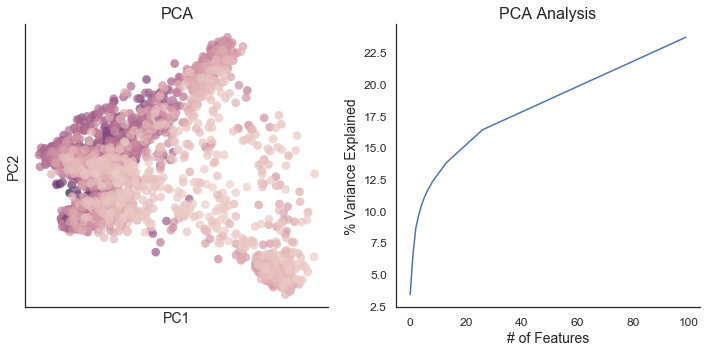

In [4]:
# arcsinh-normalize fractional counts for all 20k+ genes, and perform 100 component PCA
retina_PCA100 = fcc_PCA(retina.arcsinh_norm(norm='l1'), n_components=100)
retina_PCA100.plot_PCA()

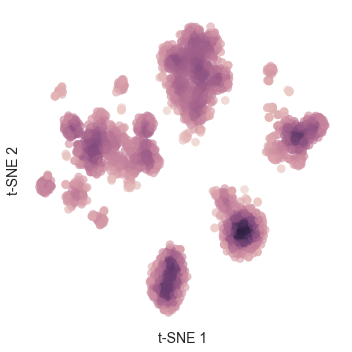

CPU times: user 37.8 s, sys: 732 ms, total: 38.5 s
Wall time: 38.4 s


In [5]:
%%time 
# now perform standard t-SNE (perplexity 30) and show results
retina_tSNE = fcc_tSNE(retina_PCA100.results, perplexity=30, seed=18)
retina_tSNE.plot()

---
#### 0.1 assign clusters
* density-peak clustering of whole-dataset t-SNE

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1314ea898>)

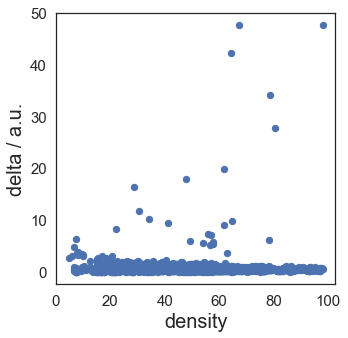

In [6]:
# show potential density-peak cluster centers
retina_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131360898>)

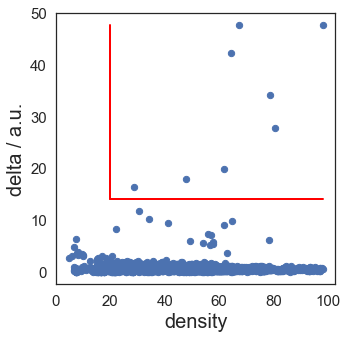

In [27]:
# assign cluster center cutoffs and show decision graph again
retina_tSNE.clu.assign(20,14)
retina_tSNE.clu.draw_decision_graph(min_delta=retina_tSNE.clu.min_delta, 
                                    min_density=retina_tSNE.clu.min_density)

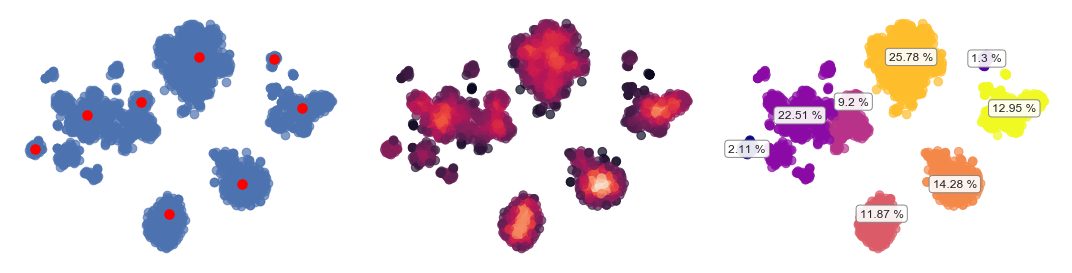

In [28]:
retina_tSNE.plot_clusters() # visualize clustering

In [29]:
retina_tSNE.cluster_counts()

57 cells in cluster 0 (2.114 %)

35 cells in cluster 1 (1.298 %)

607 cells in cluster 2 (22.515 %)

248 cells in cluster 3 (9.199 %)

320 cells in cluster 4 (11.869 %)

385 cells in cluster 5 (14.28 %)

695 cells in cluster 6 (25.779 %)

349 cells in cluster 7 (12.945 %)



In [30]:
print('Silhouette Score: {}\n'.format(retina_tSNE.silhouette_score()))

Silhouette Score: 0.5102295875549316



---
#### 0.2 filter genes and cells to manageable size
* _select variable genes_ to reduce dimension
* _downsample cells_ for future processing, maintaining cluster proportions

In [12]:
# select 500 most variable genes
retina_varselect = RNA_counts.var_select(retina, n_features=500) 

In [31]:
# choose 1600 cells with proportional representation from clusters above
retina_0 = RNA_counts.downsample_proportional(retina_varselect, retina_tSNE.clu.membership, n_cells=1650, seed=18)

In [32]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(retina_0.data.sum(axis=1).min(), retina_0.data.sum(axis=0).min()))

minimum counts per cell: 119
minimum counts per gene: 94


In [33]:
retina_0.data.shape

(1653, 500)

Let's get rid of any weird t-SNE outlier cells:

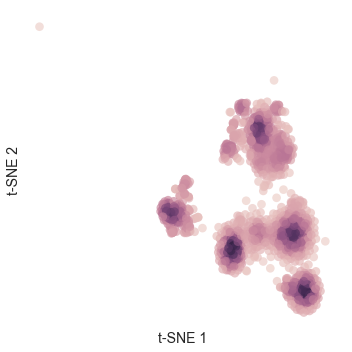

CPU times: user 23.4 s, sys: 97.8 ms, total: 23.5 s
Wall time: 23.4 s


In [34]:
%%time
retina_0_tSNE = fcc_tSNE(retina_0.arcsinh_norm(), perplexity=30, seed=1)
retina_0_tSNE.plot()

In [35]:
retina_0_tSNE.results[:,1].argmax() # get index of outlier

488

In [36]:
retina_0 = RNA_counts(retina_0.data.drop(axis=0,index=retina_0.cell_IDs[retina_0_tSNE.results[:,1].argmax()]))

In [37]:
retina_0.data.shape

(1652, 500)

Now, we can re-visualize as before to make sure we have a representative subset of the data:

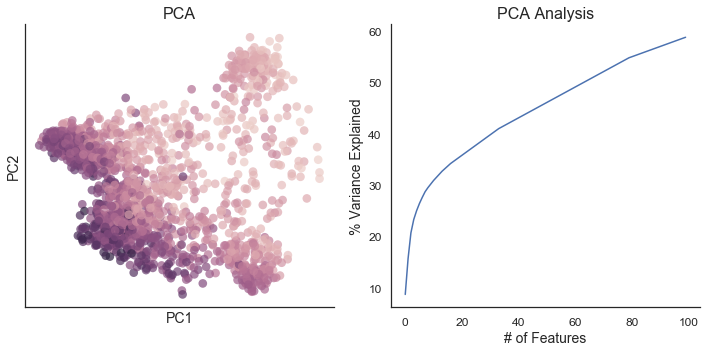

CPU times: user 1.15 s, sys: 101 ms, total: 1.25 s
Wall time: 756 ms


In [38]:
%%time
retina_0_PCA100 = fcc_PCA(matrix=retina_0.arcsinh_norm(), n_components=100)
retina_0_PCA100.plot_PCA()

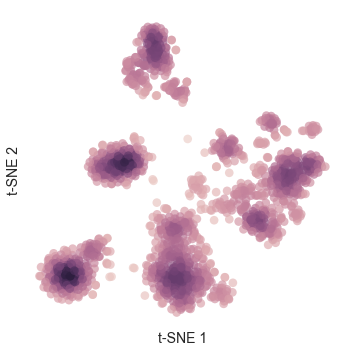

CPU times: user 17.5 s, sys: 86.1 ms, total: 17.5 s
Wall time: 17.4 s


In [39]:
%%time
retina_0_tSNE = fcc_tSNE(retina_0_PCA100.results, perplexity=30, seed=11)
retina_0_tSNE.plot()

Print out some cell type markers for cluster identification:

In [44]:
retina_0_tSNE.plot(color=retina_0.arcsinh_norm()[:,retina_0.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='../images/retina_Opn1mw.png', figsize=(6,6))

In [45]:
retina_0_tSNE.plot(color=retina_0.arcsinh_norm()[:,retina_0.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='../images/retina_Rlbp1.png', figsize=(6,6))

In [46]:
retina_0_tSNE.plot(color=retina_0.arcsinh_norm()[:,retina_0.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='../images/retina_Vsx2.png', figsize=(6,6))

In [47]:
retina_0_tSNE.plot(color=retina_0.arcsinh_norm()[:,retina_0.gene_IDs.str.contains('Pax6$')].flatten(), save_to='../images/retina_Pax6.png', figsize=(6,6))

In [48]:
retina_0_tSNE.plot(save_to='../images/retina_density.png', figsize=(6,6))

---
#### 0.3 write results to file

In [49]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.tsv', sep='\t', header=True, index=True)

In [57]:
# write file with counts as float and no cell ID labels for scvis
retina_0.data.astype('float64').to_csv('../inputs/GSM1626793_P14Retina_1.processed.norowlabels.tsv', sep='\t', header=True, index=False)

---

In [6]:
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.processed.tsv')

In [9]:
retina_PCA100 = fcc_PCA(retina.arcsinh_norm(), n_components=100)
retina_tSNE = fcc_tSNE(retina_PCA100.results, perplexity=30, seed=18)

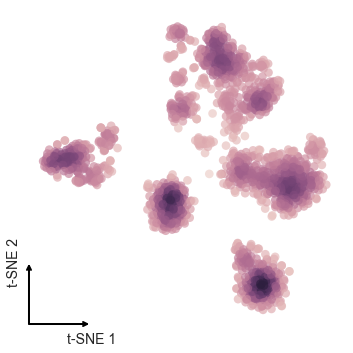

In [10]:
retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c9c4550>)

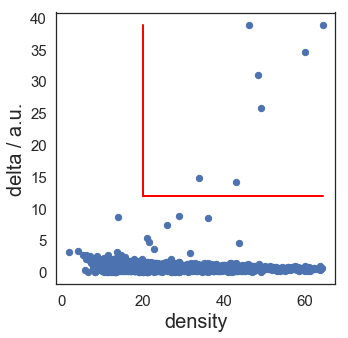

In [12]:
# assign cluster center cutoffs and show decision graph again
retina_tSNE.clu.assign(20,12)
retina_tSNE.clu.draw_decision_graph(min_delta=retina_tSNE.clu.min_delta, 
                                    min_density=retina_tSNE.clu.min_density)

In [18]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='../images/retina_Opn1mw.png', figsize=(6,6))

In [19]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='../images/retina_Rlbp1.png', figsize=(6,6))

In [20]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='../images/retina_Vsx2.png', figsize=(6,6))

In [21]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='../images/retina_Pax6.png', figsize=(6,6))

In [22]:
retina_tSNE.plot(save_to='../images/retina_density.png', figsize=(6,6))

In [27]:
np.savetxt(X=retina_tSNE.clu.membership, fname='../inputs/retina_clu.csv', delimiter=',')

---
#### 1.0 read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [28]:
colon = RNA_counts.from_file(datafile='../inputs/GSM2743164_rep1_colon_rnaseq_filtered.tsv.gz', labels=[None, 0])

In [29]:
# see how many cells and genes are present in whole counts matrix
colon.data.shape

(1653, 25507)

This cell number is already what we want.  Let's just select the 500 most variable genes and visualize the dataset.

---
#### 1.1 filter genes to manageable size
* _select variable genes_ to reduce dimension

In [30]:
# select 500 most variable genes
colon_0 = RNA_counts.var_select(colon, n_features=500) 

In [31]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(colon_0.data.sum(axis=1).min(), colon_0.data.sum(axis=0).min()))

minimum counts per cell: 138
minimum counts per gene: 541


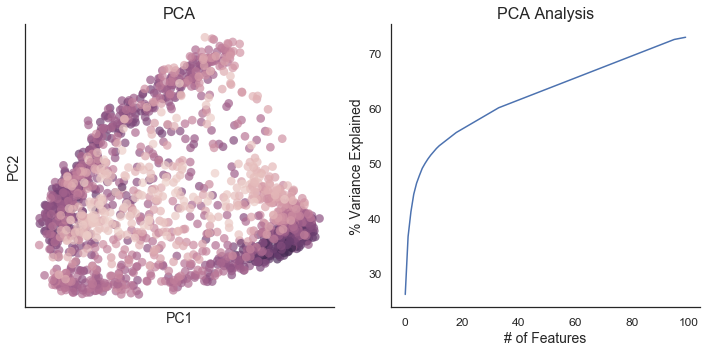

CPU times: user 1.18 s, sys: 109 ms, total: 1.29 s
Wall time: 805 ms


In [32]:
%%time
colon_0_PCA100 = fcc_PCA(matrix=colon_0.arcsinh_norm(), n_components=100)
colon_0_PCA100.plot_PCA()

In [35]:
%%time
colon_0_tSNE = fcc_tSNE(colon_0_PCA100.results, perplexity=30, seed=11)

CPU times: user 19.3 s, sys: 63.1 ms, total: 19.3 s
Wall time: 19.4 s


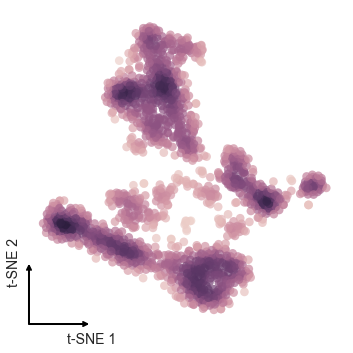

In [36]:
colon_0_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ca37470>)

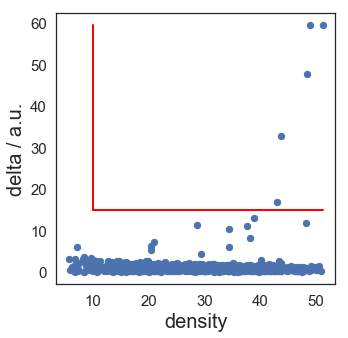

In [37]:
# assign cluster center cutoffs and show decision graph again
colon_0_tSNE.clu.assign(10,15)
colon_0_tSNE.clu.draw_decision_graph(min_delta=colon_0_tSNE.clu.min_delta, 
                                    min_density=colon_0_tSNE.clu.min_density)

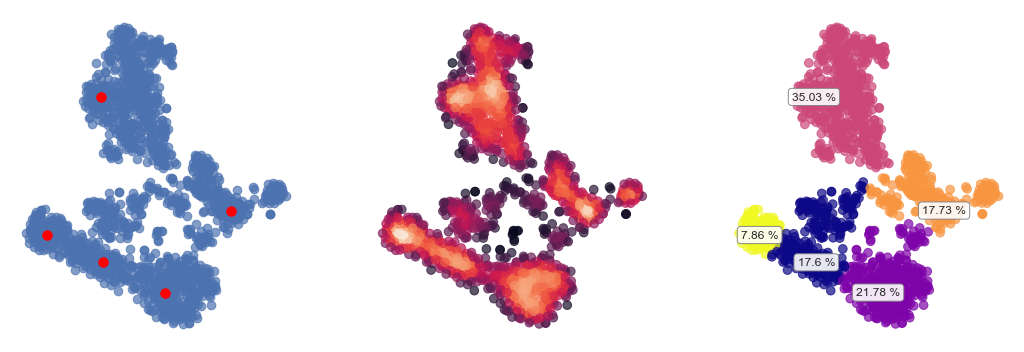

In [38]:
colon_0_tSNE.plot_clusters() # visualize clustering

In [39]:
colon_0_tSNE.silhouette_score()

0.5123119

Print out some cell type markers for cluster identification:

In [41]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt8'].flatten(), save_to='../images/colon_Krt8.png', figsize=(6,6))

In [42]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Cd8a'].flatten(), save_to='../images/colon_Cd8a.png', figsize=(6,6))

In [43]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='../images/colon_Muc2.png', figsize=(6,6))

In [44]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='../images/colon_Krt20.png', figsize=(6,6))

In [45]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='../images/colon_Reg4.png', figsize=(6,6))

In [46]:
colon_0_tSNE.plot(save_to='../images/colon_density.png', figsize=(6,6))

---
#### 1.2 write results to file

In [57]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', sep='\t', header=True, index=True)

In [62]:
# write file with counts as float and no cell ID labels for scvis
colon_0.data.astype('float64').to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv', sep='\t', header=True, index=False)

In [47]:
np.savetxt(X=colon_0_tSNE.clu.membership, fname='../inputs/colon_clu.csv', delimiter=',')